# Instructions/Notes
This notebook is sectioned into pre-processing and classification. To get results, run all cells

Notes:

*  The "Results" section at the bottom of the notebook contains LaTeX table data & is not part of the code to run.

*   If you are uploding your data file from Google Drive, type function: df_labeled = prepare_dataset('drive') otherwise, if uploading the file to the workspace, type function: df_labeled = prepare_dataset('local') below, under "Data Set-Up"


# Imports & Setup

## Imports

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Misc
import matplotlib.pyplot as plt
import pickle
import copy

# Model(s)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# NLP
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Helper functions
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Set-Up

In [3]:
def prepare_dataset(drive_or_local):
  if drive_or_local == 'drive':
    df_labeled = pd.read_csv('/content/drive/MyDrive/Cogs 118b Final Project/df_labeled.csv')
  elif drive_or_local == 'local':
    df_labeled = pd.read_csv('df_labeled.csv')
  else:
    return 0
  df_labeled = df_labeled.dropna(subset=['title'])
  return df_labeled

In [4]:
#Importing from Google Drive? Uncomment the line below, comment out the last line, click "Run"
#df_labeled = prepare_dataset('drive')
df_labeled = prepare_dataset('local')

## Helper Functions

In [5]:
def prep_data(newsdf, feature_list): 
  data = []
  for feature in feature_list:
      data.append(np.array(newsdf.get(feature)))
  formatted_data = np.array(data).T
  return formatted_data

In [6]:
def return_predict_acc(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred)

In [7]:
def train_unsupervised_models(estimator, train_dict, test_dict, output_path=None):
    '''
    Trains an unsupervised classification model on multiple training/testing data sets

    Args:
    - estimator: model to be trained
    - train_dict (dict): dictionary of training data
    - test_dict (dict): dictionary of training data
    - output_path=None (str): location to save the best model to

    The training and testing dictionaries are of the form
    'data key': (X, y)
    where X corresponds to features to be trained on, and y corresponds to labels
    '''

    # Print which model we're training on
    model_type = estimator.__class__.__name__
    print(model_type)

    # Variables for saving best model
    best_acc = 0.0
    best_estimator = None
    fitted_estimators = []

    for (train_title, (X_train, y_train)), (test_title, (X_test, y_test)) in zip(train_dict.items(), test_dict.items()):
        # Ensure the correct data is being trained/tested together
        assert train_title == test_title, 'Data is mismatched for train/test split'

        # Train model and gather accuracies
        fitted_estimator = estimator.fit(X_train)
        fitted_estimators.append(fitted_estimator)
        acc_train = return_predict_acc(estimator, X_train, y_train)
        acc_test = return_predict_acc(estimator, X_test, y_test)

        # Flip acc's if under baseline
        acc_train = max(acc_train, 1-acc_train)
        acc_test = max(acc_test, 1-acc_test)

        # Update best model
        if acc_test > best_acc:
            best_acc = acc_test
            best_estimator = copy.deepcopy(estimator)

        # Print results
        print('\t{} train: {}'.format(train_title, acc_train))
        print('\t{} test: {}\n'.format(test_title, acc_test))

    # Save the best model (if required)
    if output_path is not None:
        with open(output_path, 'wb') as filename:
            pickle.dump(best_estimator, filename)
    return fitted_estimators

In [8]:
def train_supervised_models(estimator, train_dict, test_dict, output_path=None):
    '''
    Trains a supervised classification model on multiple training/testing data sets

    Args:
    - estimator: model to be trained
    - train_dict (dict): dictionary of training data
    - test_dict (dict): dictionary of training data
    - output_path=None (str): location to save the best model to

    The training and testing dictionaries are of the form
    'data key': (X, y)
    where X corresponds to features to be trained on, and y corresponds to labels
    '''

    # Print which model we're training on
    model_type = estimator.__class__.__name__
    print(model_type)

    # Variables for saving best model
    best_acc = 0.0
    best_estimator = None
    fittedEstimators = []

    for (train_title, (X_train, y_train)), (test_title, (X_test, y_test)) in zip(train_dict.items(), test_dict.items()):
        # Ensure the correct data is being trained/tested together
        assert train_title == test_title, 'Data is mismatched for train/test split'

        # Train model and gather accuracies
        fittedEstimator = estimator.fit(X_train, y_train)
        fittedEstimators.append(fittestEstimator)
        acc_train = return_predict_acc(estimator, X_train, y_train)
        acc_test = return_predict_acc(estimator, X_test, y_test)

        # Update best model
        if acc_test > best_acc:
            best_acc = acc_test
            best_estimator = copy.deepcopy(estimator)

        # Print results
        print('\t{} train: {}'.format(train_title, acc_train))
        print('\t{} test: {}\n'.format(test_title, acc_test))

    # Save the best model (if required)
    if output_path is not None:
        with open(output_path, 'wb') as filename:
            pickle.dump(best_estimator, filename)
    return fittedEstimators

In [9]:
def train_models(estimator, train_dict, test_dict, is_supervised=False, output_path=None):
    '''
    Passes data to respective function for model training

    Args:
    - estimator: model to be trained
    - train_dict (dict): dictionary of training data
    - test_dict (dict): dictionary of training data
    - is_supervised (bool): specifies is model is supervised, for purpose of switching labels
    - output_path=None (str): location to save the best model to

    The training and testing dictionaries are of the form
    'data key': (X, y)
    where X corresponds to features to be trained on, and y corresponds to labels
    '''
    if is_supervised:
        fittedEstimator = train_supervised_models(estimator, train_dict, test_dict, output_path)
    else: 
        fittedEstimator = train_unsupervised_models(estimator, train_dict, test_dict, output_path)
    return fittedEstimator

# Pre-processing

## Read, Edit, Partition Data

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')

## TF-IDF

This cell reads in the full data, and utilizes TF-IDF scores for the top 2000 words in the vocabulary for the article titles. Additional cleaning is done to ensure that there are no empty titles included in the analysis.

In [11]:
vectorizer = TfidfVectorizer(sublinear_tf = True,
                            analyzer = 'word',
                            stop_words = 'english',
                            max_features = 2000,
                            tokenizer = word_tokenize)

X_tfidf = vectorizer.fit_transform(df_labeled['title']).toarray()
y = df_labeled['label'].to_numpy()

## Variable Configuration

In [12]:
#Strings for names of features from dataset -- easy to call variable instead of string
label_feature = 'label'
compound_feature = 'compound'
num_words_feature = 'num words'
num_chars_feature = 'num characters'
pos_feature = 'pos'
neg_feature = 'neg'
neu_feature = 'neu'

#Labels for eat data point
labels = np.array(df_labeled.get('label'))

#Random state applied to train/testing dataset splits
RANDOM_STATE = 42

## Add Sentiment

In [13]:
X_combined = np.hstack([X_tfidf, df_labeled['compound'].to_numpy().reshape(-1,1)])

# Determine optimal number of features for PCA

In [14]:
def bestNforPCA(data):
  '''
  Passes dataset to determine which number of features PCA should reduce down to (optimality determined by highest accuracy)

  Args:
  - data: dataset containing features regarding article titles 

  Return Value:
  - df: dataset that contains accuracy for each number of features PCA reduced down to
  '''

  df = pd.DataFrame() 
  numRows, numCols = np.shape(data)

  #For every 100 values of N features, iterate and run PCA
  for i in range (100, numCols+1, 100):
    pca = PCA(n_components=i).fit(data)
    tfidf_X_pca = pca.transform(data)

    #Following PCA run, split data into test/train 
    tfidf_X_pca_train, tfidf_X_pca_test, tfidf_y_pca_train, tfidf_y_pca_test = train_test_split(tfidf_X_pca, y, train_size=0.8, random_state=RANDOM_STATE, shuffle=True)
    
    #Apply K-Means to dataset which already has PCA applied to it
    kmeans = KMeans(2, random_state=0).fit(tfidf_X_pca_train)  
    km_labels = kmeans.labels_

    #Determine accuracy of labels 
    accuracy = accuracy_score(km_labels, tfidf_y_pca_train)
    new_row = {'N Value PCA':i, 'accuracies':accuracy}
    df = df.append(new_row, ignore_index=True)
  return df

In [15]:
# bestN = bestNforPCA(X_tfidf)
# bestN

In [16]:
#highest accuracy yielded by N = 300
optimal_N_features_PCA = 300

## Apply PCA

In [17]:
pca = PCA(n_components=optimal_N_features_PCA)
X_tfidf_pca = pca.fit_transform(X_tfidf)
X_combined_pca = pca.fit_transform(X_combined)

## Split data

In [18]:
# TF-IDF
X_tfidf_train, \
X_tfidf_test, \
y_tfidf_train, \
y_tfidf_test = train_test_split(X_tfidf, y, train_size=0.8, random_state=RANDOM_STATE, shuffle=True)

# TF-IDF, PCA
X_tfidf_pca_train, \
X_tfidf_pca_test, \
y_tfidf_pca_train, \
y_tfidf_pca_test = train_test_split(X_tfidf_pca, y, train_size=0.8, random_state=RANDOM_STATE, shuffle=True)

# TF-IDF, Sentiment
X_combined_train, \
X_combined_test, \
y_combined_train, \
y_combined_test = train_test_split(X_combined, y, train_size=0.8, random_state=RANDOM_STATE, shuffle=True)

# TF-IDF, Sentiment, PCA
X_combined_pca_train, \
X_combined_pca_test, \
y_combined_pca_train, \
y_combined_pca_test = train_test_split(X_combined_pca, y, train_size=0.8, random_state=RANDOM_STATE, shuffle=True)

In [19]:
X_tfidf_train.shape, X_tfidf_test.shape

((35911, 2000), (8978, 2000))

In [20]:
train_dict = {'tfidf': (X_tfidf_train, y_tfidf_train), 
                 'tfidf/pca': (X_tfidf_pca_train, y_tfidf_pca_train), 
                 'tfidf/sentiment': (X_combined_train, y_combined_train), 
                 'tfidf/sentiment/pca': (X_combined_pca_train, y_combined_pca_train)}

test_dict = {'tfidf': (X_tfidf_test, y_tfidf_test), 
                'tfidf/pca': (X_tfidf_pca_test, y_tfidf_pca_test), 
                'tfidf/sentiment': (X_combined_test, y_combined_test), 
                'tfidf/sentiment/pca': (X_combined_pca_test, y_combined_pca_test)}

# Classify Data

## SVM

In [21]:
# svc = SVC()
# train_models(svc, train_dict, test_dict, is_supervised=True)

## Random Forest

In [22]:
# rf = RandomForestClassifier()
# train_models(rf, train_dict, test_dict, is_supervised=True)

## K-Means - SK Learn

In [23]:
km = KMeans(n_clusters=2, random_state=0)
km_trained = train_models(km, train_dict, test_dict, output_path='kmeans.pkl')

KMeans
	tfidf train: 0.6063044749519646
	tfidf test: 0.6041434617955002

	tfidf/pca train: 0.606276628331152
	tfidf/pca test: 0.6041434617955002

	tfidf/sentiment train: 0.5957227590431902
	tfidf/sentiment test: 0.5975718422811316

	tfidf/sentiment/pca train: 0.5957506056640027
	tfidf/sentiment/pca test: 0.5975718422811316



In [24]:
def bestFeaturesNoTFIDF(newsdf, labels, dim):
  feature_list = [compound_feature, num_words_feature, num_chars_feature, pos_feature, neg_feature, neu_feature]
  df = pd.DataFrame() 
  
  if dim == '2D':
    for feature1 in feature_list:
      char_feature_list = ''
      data = []
      for feature2 in feature_list:
        if (feature1 == feature2):
          continue
        else:
          data = prep_data(newsdf, [feature1, feature2])
          char_feature_list = feature1 + feature2
          kmeans = KMeans(2, random_state=0).fit(data)
          km_labels = kmeans.labels_
          accuracy = accuracy_score(km_labels, labels)
          new_row = {'featurenames':char_feature_list, 'accuracies':accuracy}
          df = df.append(new_row, ignore_index=True)
  else:
    for feature1 in feature_list:
      char_feature_list = ''
      data = []
      for feature2 in feature_list:
        for feature3 in feature_list:
            data = prep_data(newsdf, [feature1, feature2, feature3])
            char_feature_list = feature1 + feature2 + feature3
            kmeans = KMeans(2, random_state=0).fit(data)
            km_labels = kmeans.labels_
            accuracy = accuracy_score(km_labels, labels)
            new_row = {'featurenames':char_feature_list, 'accuracies':accuracy}
            df = df.append(new_row, ignore_index=True)
  return df

## K-Means: Our Own Implementation (Referenced parts of code from Homework 2 solutions)

In [25]:
def calcSqDistances(X, Kmus):
    return ((-2 * X.dot(Kmus.T) + np.sum(Kmus*Kmus, axis=1).T).T + np.sum(X*X, axis=1)).T

In [26]:
def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis=1)
    return np.eye(sqDmat.shape[1])[m]

In [27]:
def recalcMus(X, Rnk):
    return (np.divide(X.T.dot(Rnk), np.sum(Rnk, axis=0))).T

In [28]:
def runKMeans(K, X, plotdim='2D'):
    
    # Determine and store data set information
    N = np.shape(X)[0]
    D = np.shape(X)[1]

    # Allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    # Initialize cluster centers by randomly picking points from the data
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];

    # Specify the maximum number of iterations to allow
    maxiters = 1000;

    for iter in range(maxiters):
        # Assign each data vector to closest mu vector as per Bishop (9.2)
        # Do this by first calculating a squared distance matrix where the n,k entry
        # contains the squared distance from the nth data vector to the kth mu vector

        # sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus);

        # given the matrix of squared distances, determine the closest cluster center for each data vector 

        # R is the "responsibility" matrix
        # R will be an N-by-K matrix of binary values whose n,k entry is set as per Bishop (9.2)
        # Specifically, the n,k entry is 1 if point n is closest to cluster k, and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        #plotCurrent(X, Rnk, Kmus, dim=plotdim)
        plt.show()

        # Recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        # Check to see if the cluster centers have converged.  If so, break.
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break

    return plotCurrent(X,Rnk,Kmus, dim=plotdim)

In [29]:
def plotCurrent(X, Rnk, Kmus, dim):
    N, D = np.shape(X)
    K = np.shape(Kmus)[0]

    InitColorMat = np.matrix([[1, 0, 0], 
                              [0, 1, 0],   
                              [0, 0, 1],
                              [0, 0, 0],
                              [1, 1, 0], 
                              [1, 0, 1], 
                              [0, 1, 1]])

    KColorMat = InitColorMat[0:K]
    colorVec = Rnk.dot(KColorMat)
    muColorVec = np.eye(K).dot(KColorMat)

    if dim=='2D':
        plt.scatter(X[:,0], X[:,1], edgecolors=colorVec, facecolors='none', alpha=0.3)
        plt.scatter(Kmus[:,0], Kmus[:,1], c=muColorVec, marker='D', s=50)
   
    else: #plot 3d
        fig = plt.figure(figsize=(5,5))
        ax0 = fig.add_subplot(projection='3d')
        ax0.scatter(X[:,0], X[:,1], X[:,2], c=colorVec) 
    
    return np.array(colorVec)[:,0]

In [30]:
def convertToDF(X):
  df = pd.DataFrame(X)
  return df

In [31]:
def convertToNPArray(df):
  arr = df.to_numpy(X)
  return arr

In [32]:
# A function to check what % of the labels were grouped correctly - works for 2d and 3d
def check_acc(km_labels, real_labels):
    same_order = np.sum(km_labels == labels) / len(labels)
    # because of the nature of clustering, the actual naming of the two groups doesn't need to match exactly
    diff_order = np.sum(km_labels != labels) / len(labels)
    acc_fraction = max(same_order, diff_order) 
    print('The accuracy fraction is: ',acc_fraction)
    return acc_fraction

In [33]:
# A function to plot the real labels in 3d (for comparison to the k-means plot)
def plot_real_labels(data, labels, angle1=0, angle2=0, title='3d real labels', xlbl='x', ylbl='y', flip=True):
    if flip:   #because the groups may be named differently, this variable 'flips' all bits so the colors match
      labels=1-labels
    fig = plt.figure(figsize=(5,5))
    ax0 = fig.add_subplot(projection='3d')
    ax0.scatter(data[:,0], data[:,1], data[:,2], c=labels)
    #ax0.view_init(angle1, angle2)
    ax0.set_title(title) 
    ax0.set_xlabel(xlbl)
    ax0.set_ylabel(ylbl)

## Mixture of Gaussian

In [34]:
# mog = GaussianMixture(n_components=2)
# train_models(mog, train_dict, test_dict, output_path='mog.pkl')

# Results: SK Learn Implementation

```
% Please add the following required packages to your document preamble:
% \usepackage{booktabs}

\begin{table}[]
\begin{tabular}{@{}ll@{}}
\toprule
Model   & Perfomance \\ \midrule
K-Means & 76.92\%    \\
MOG     & 
SVM     & 95.17\%    \\
RF      & 94.16\%    \\ \bottomrule
\end{tabular}
\end{table}
```

In [35]:
# bestFeaturesDF2D = bestFeaturesNoTFIDF(df_labeled, df_labeled['label'], '2D')
# bestFeaturesDF2D

In [36]:
# bestFeaturesDF2D['Model ID'] = range(0, 30)
# plt.figure(figsize=(20, 10))
# plt.scatter(bestFeaturesDF2D['Model ID'], bestFeaturesDF2D['accuracies'])
# plt.xlabel("Model ID")
# plt.ylabel("Accuracy")
# plt.title("2D Feature Combinations: Model ID vs. Accuracy")

In [37]:
# bestFeaturesDF3D = bestFeaturesNoTFIDF(df_labeled, df_labeled['label'], '3D')
# bestFeaturesDF3D

In [38]:
# bestFeaturesDF3D['Model ID'] = range(0, 216)
# plt.figure(figsize=(20, 10))
# plt.scatter(bestFeaturesDF3D['Model ID'], bestFeaturesDF3D['accuracies'])
# plt.xlabel("Model ID")
# plt.ylabel("Accuracy")
# plt.title("3D Feature Combinations: Model ID vs. Accuracy")

#Results: K-Means SK Learn Implementation - Plots

In [39]:
#tfidf, tfidf+pca, tfidf+sentiment, tfidf+sentiment+pca

## Sentiment (All Features)

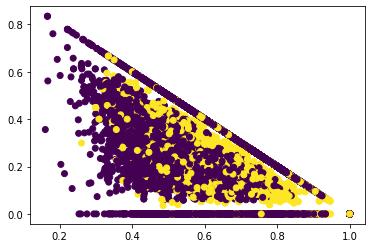

In [40]:
dataSentiment = prep_data(df_labeled, [neu_feature, neg_feature, pos_feature, compound_feature, num_words_feature, num_chars_feature])
Xtrain, Xtest, ytrain, ytest = train_test_split(dataSentiment, labels, train_size=0.8, random_state=42, shuffle=True)
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=km_labels)


Text(0.5, 1.0, 'Real Labels: Neutral Sentiment Score vs. Number of Words')

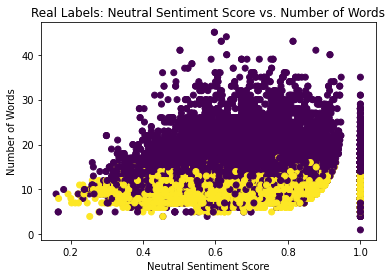

In [41]:
dataSentiment = prep_data(df_labeled, [neu_feature, num_words_feature])
Xtrain, Xtest, ytrain, ytest = train_test_split(dataSentiment, labels, train_size=0.8, random_state=42, shuffle=True)
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=ytrain)
plt.xlabel('Neutral Sentiment Score')
plt.ylabel('Number of Words')
plt.title("Real Labels: Neutral Sentiment Score vs. Number of Words")

Text(0.5, 1.0, 'K-Means Labels: Neutral Sentiment Score vs. Number of Words')

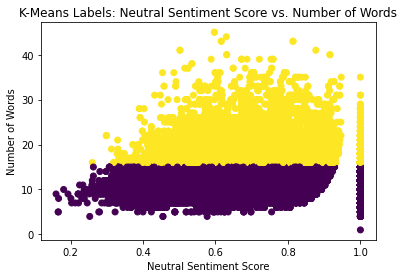

In [42]:
dataSentiment = prep_data(df_labeled, [neu_feature, num_words_feature])
Xtrain, Xtest, ytrain, ytest = train_test_split(dataSentiment, labels, train_size=0.8, random_state=42, shuffle=True)
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=km_labels)
plt.xlabel('Neutral Sentiment Score')
plt.ylabel('Number of Words')
plt.title("K-Means Labels: Neutral Sentiment Score vs. Number of Words")

Text(0.5, 1.0, 'K-Means Labels: Positive Sentiment Score vs. Number of Words')

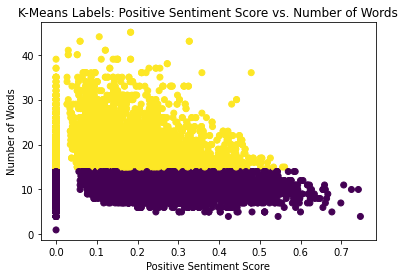

In [43]:
dataSentiment = prep_data(df_labeled, [pos_feature, num_words_feature])
Xtrain, Xtest, ytrain, ytest = train_test_split(dataSentiment, labels, train_size=0.8, random_state=42, shuffle=True)
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=km_labels)
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Number of Words')
plt.title("K-Means Labels: Positive Sentiment Score vs. Number of Words")

Text(0.5, 1.0, 'Real Labels: Positive Sentiment Score vs. Number of Words')

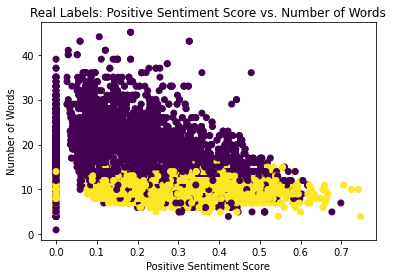

In [44]:
dataSentiment = prep_data(df_labeled, [pos_feature, num_words_feature])
Xtrain, Xtest, ytrain, ytest = train_test_split(dataSentiment, labels, train_size=0.8, random_state=42, shuffle=True)
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=ytrain)
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Number of Words')
plt.title("Real Labels: Positive Sentiment Score vs. Number of Words")

Text(0.5, 1.0, 'Real Labels: Positive Sentiment Score vs. Number of Words')

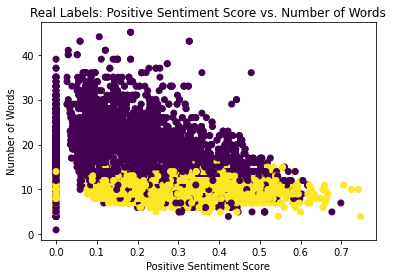

In [45]:
dataSentiment = prep_data(df_labeled, [pos_feature, num_words_feature])
Xtrain, Xtest, ytrain, ytest = train_test_split(dataSentiment, labels, train_size=0.8, random_state=42, shuffle=True)
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=ytrain)
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Number of Words')
plt.title("Real Labels: Positive Sentiment Score vs. Number of Words")

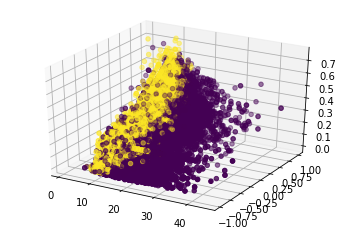

In [46]:
dataSentiment = prep_data(df_labeled, [pos_feature, num_words_feature, compound_feature])
Xtrain, Xtest, ytrain, ytest = train_test_split(dataSentiment, labels, train_size=0.8, random_state=42, shuffle=True)
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = Xtrain[:,0]
xdata = Xtrain[:,1]
ydata = Xtrain[:,2]
ax.scatter3D(xdata, ydata, zdata, c=ytrain);

## TF-IDF

Text(0, 0.5, 'K-Means TF-IDF Axis 2')

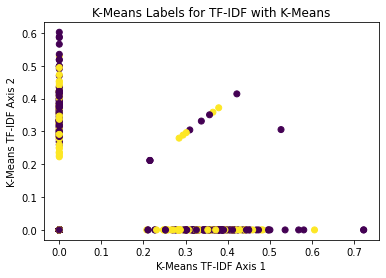

In [47]:
plt.scatter(X_tfidf_train[:,0], X_tfidf_train[:,1], c=km_trained[0].labels_)
plt.title("K-Means Labels for TF-IDF with K-Means")
plt.xlabel("K-Means TF-IDF Axis 1")
plt.ylabel("K-Means TF-IDF Axis 2")

Text(0, 0.5, 'K-Means TF-IDF Axis 2')

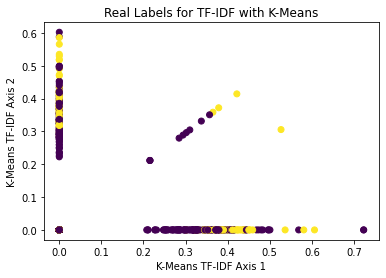

In [48]:
plt.scatter(X_tfidf_train[:,0], X_tfidf_train[:,1], c=y_tfidf_train)
plt.title("Real Labels for TF-IDF with K-Means")
plt.xlabel("K-Means TF-IDF Axis 1")
plt.ylabel("K-Means TF-IDF Axis 2")

## TF-IDF + PCA

Text(0, 0.5, 'Principal Component 2')

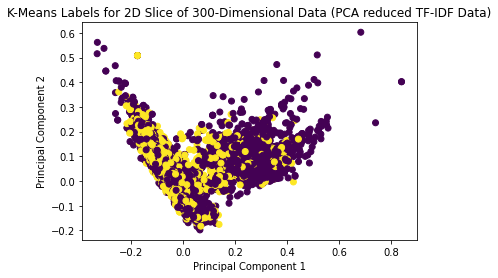

In [49]:
plt.scatter(X_tfidf_pca_train[:,0], X_tfidf_pca_train[:,1], c=km_trained[1].labels_)
plt.title("K-Means Labels for 2D Slice of 300-Dimensional Data (PCA reduced TF-IDF Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Text(0, 0.5, 'Principal Component 2')

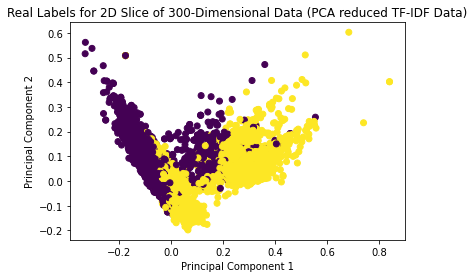

In [50]:
plt.scatter(X_tfidf_pca_train[:,0], X_tfidf_pca_train[:,1], c=y_tfidf_pca_train)
plt.title("Real Labels for 2D Slice of 300-Dimensional Data (PCA reduced TF-IDF Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

## TFIDF + Sentiment

Text(0, 0.5, 'Principal Component 2')

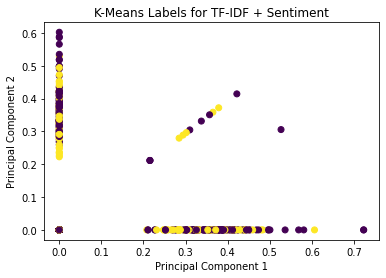

In [51]:
plt.scatter(X_combined_train[:,0], X_combined_train[:,1], c=km_trained[2].labels_)
plt.title("K-Means Labels for TF-IDF + Sentiment")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Text(0, 0.5, 'Principal Component 2')

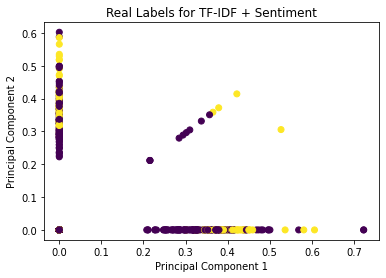

In [52]:
plt.scatter(X_combined_train[:,0], X_combined_train[:,1], c=y_combined_train)
plt.title("Real Labels for TF-IDF + Sentiment")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

## TF-IDF + Sentiment + PCA

Text(0, 0.5, 'Principal Component 2')

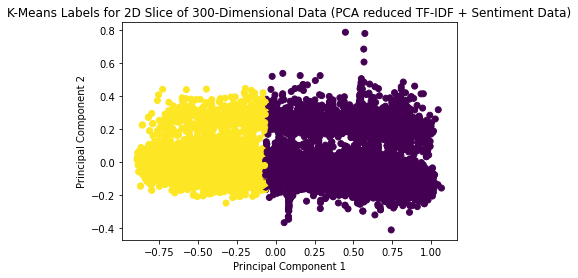

In [53]:
plt.scatter(X_combined_pca_train[:,0], X_combined_pca_train[:,1], c=km_trained[3].labels_)
plt.title("K-Means Labels for 2D Slice of 300-Dimensional Data (PCA reduced TF-IDF + Sentiment Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Text(0, 0.5, 'Principal Component 2')

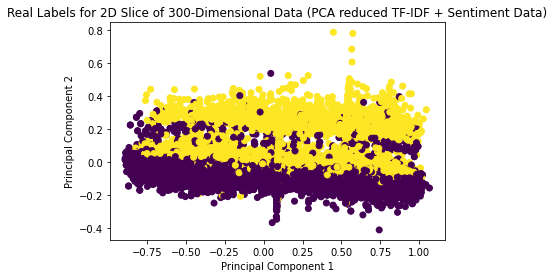

In [54]:
plt.scatter(X_combined_pca_train[:,0], X_combined_pca_train[:,1], c=y_combined_pca_train)
plt.title("Real Labels for 2D Slice of 300-Dimensional Data (PCA reduced TF-IDF + Sentiment Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Results: Our Own K-Means Implementation

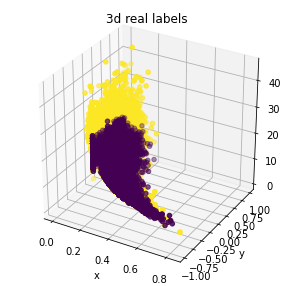

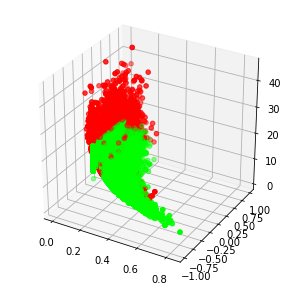

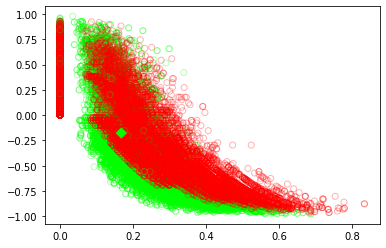

The accuracy fraction is:  0.7492258682528014


0.7492258682528014

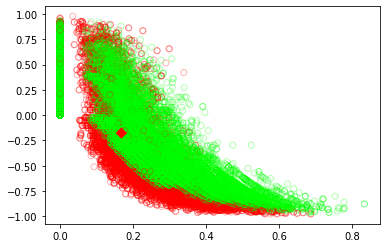

In [55]:
data = prep_data(df_labeled, [neg_feature, compound_feature, num_words_feature])
plot_real_labels(data, labels)
km_labels = runKMeans(2, data, plotdim='3D')
km_labels = runKMeans(2, data, plotdim='2D')
data44 = prep_data(df_labeled, [neg_feature, num_words_feature, num_chars_feature, pos_feature])
km_labels = runKMeans(2, data, plotdim='2D')
check_acc(km_labels, labels)